In [653]:
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.losses import logcosh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.metrics import CosineSimilarity
from thesispack.models import BaseNeuralNetwork, MetricBase, LossBase, LogCosMetric, WeightedCrossEntropyLogitsMetric
import tensorflow as tf
from thesispack.methods import history_figure

In [3]:
df=pd.read_csv(
    StringIO(
        str(
            np.load("../data/Data.zip")['RTT_data.csv'],
            'utf-8'
    )))

Index(['%Timestamp[s]', 'GroundTruthPositionX[m]', 'GroundTruthPositionY[m]',
       'GroundTruthPositionZ[m]', 'ML_range_estimate[m]', 'AP_positionX[m]',
       'AP_positionY[m]', 'AP_positionZ[m]', 'AP_index', 'GroundTruthRange[m]',
       ...
       'channel_side2_ant2_tone105', 'channel_side2_ant2_tone106',
       'channel_side2_ant2_tone107', 'channel_side2_ant2_tone108',
       'channel_side2_ant2_tone109', 'channel_side2_ant2_tone110',
       'channel_side2_ant2_tone111', 'channel_side2_ant2_tone112',
       'channel_side2_ant2_tone113', 'channel_side2_ant2_tone114'],
      dtype='object', length=467)

In [5]:
for k in df.keys():
    print(k)
    if k == "channel_side1_ant1_tone  1":
        break

%Timestamp[s]
GroundTruthPositionX[m]
GroundTruthPositionY[m]
GroundTruthPositionZ[m]
ML_range_estimate[m]
AP_positionX[m]
AP_positionY[m]
AP_positionZ[m]
AP_index
GroundTruthRange[m]
ToD_factor[m]
channel_side1_ant1_tone  1


In [356]:
dft_d = np.gradient(df['%Timestamp[s]'])
new_m_ind = [0] + list(np.where(dft_d < -750)[0][::2]) + [len(df)]
new_m_ind

[0, 12049, 22687, 29581]

In [644]:
dt = 10
max_pad = 17
tods_ap = []
ps_xy = []

for i in range(len(new_m_ind)-1):
    dfmini = df.loc[new_m_ind[i]+2:new_m_ind[i+1]+1]

    mint = dfmini["%Timestamp[s]"].min()
    dfmini["%Timestamp[s]"] += -mint
    widx = 0
    while True:
        tod_ap = []
        data = dfmini[(dfmini["%Timestamp[s]"] <= dt*(widx+1)) & (dfmini["%Timestamp[s]"] > dt*widx)][[
            'GroundTruthPositionX[m]',
            'GroundTruthPositionY[m]',
            'AP_index',
            'ToD_factor[m]'
        ]]
        if len(data) == 0:
            break
        for i in range(1, 13):
            tod_ap.append(data[data["AP_index"] == i]["ToD_factor[m]"].to_numpy())
        tods_ap.append(pad_sequences(tod_ap, padding="post", maxlen=max_pad))
        ps_xy.append(
            data[[
                'GroundTruthPositionX[m]',
                'GroundTruthPositionY[m]'
            ]].tail(1).to_numpy()[0]
        )
        widx += 1

tods_ap = np.array(tods_ap)
ps_xy = np.array(ps_xy)
# tods_ap = gaussian_filter1d(tods_ap, axis=2, sigma=1)
# tods_ap = np.divide(tods_ap - np.mean(tods_ap, axis=0), np.std(tods_ap, axis=0))
# ps_xy = np.divide(ps_xy - np.mean(ps_xy, axis=0),  np.std(ps_xy, axis=0))

N_tr = tods_ap.shape[0]
np.random.seed(5287231)
Rarray = np.random.choice(np.arange(0, N_tr), replace=False, size=(1, N_tr)).reshape(N_tr)
tods_ap = tods_ap[Rarray]



ps_xy = ps_xy[Rarray]
train_tod, test_tod, train_pxy, test_pxy = train_test_split(tods_ap, ps_xy, test_size=0.2)


train = tf.data.Dataset.from_tensor_slices((
            tf.cast(train_tod, tf.float32),
            tf.cast(train_pxy, tf.float32),
        )).batch(1000)

    # val = tf.data.Dataset.from_tensor_slices((
    #         tf.cast(val_tod, tf.float32),
    #         tf.cast(val_pxy, tf.float32),
    #     )).batch(128)

test = tf.data.Dataset.from_tensor_slices((
            tf.cast(test_tod, tf.float32),
            tf.cast(test_pxy, tf.float32),
        )).batch(1000)

<ipython-input-644-10af7a732d1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmini["%Timestamp[s]"] += -mint
<ipython-input-644-10af7a732d1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmini["%Timestamp[s]"] += -mint
<ipython-input-644-10af7a732d1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

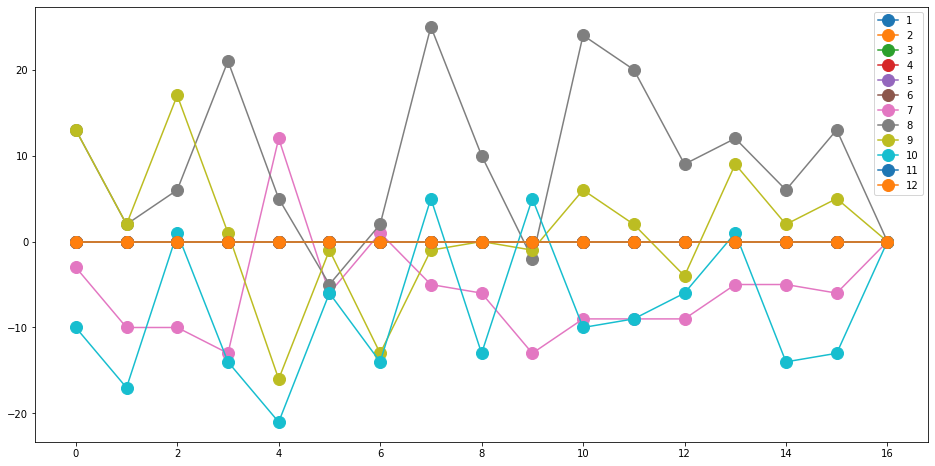

In [645]:
plt.figure(figsize=(16, 8))
for i, td in enumerate(tods_ap[10]):
    plt.plot(td, '-o', label=i+1, markersize=12)
plt.legend()

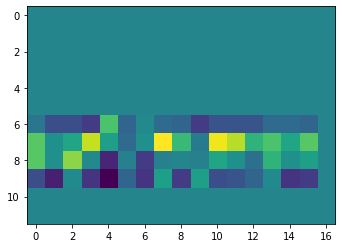

In [646]:
plt.imshow(tods_ap[10])

In [654]:
class RTT_CNN1D(Model, BaseNeuralNetwork):

    def __init__(self):
        Model.__init__(self, name="rtt_cnn")
        status = [
            [0],
            [1,2]
        ]
        es = {'es_strategy':'patience', 'es_metric':'val_cost', 'es_min_delta': 0.01, 'es_patience': 20 }
        BaseNeuralNetwork.__init__(self, status, None, None, "Adam", 1e-4)
        self.score_mtr = MetricBase(self,
            [CosineSimilarity()],
            status,
            [0]
        )

        self.cost_mtr = MetricBase(self,
            [LogCosMetric()],
            status,
            [0],
            1
        )

        self.cost_loss = LossBase(self,
          [lambda y, y_: logcosh(y, y_)],
          status,
          [0]
        )

        self.batch = BatchNormalization()
        # self.lstm1 =  LSTM(64, return_sequences=True,name="lstm1")
        # self.bidirectional1 = Bidirectional(self.lstm1,name="bidirectional1")
        #
        # self.lstm2 =  LSTM(64, return_sequences=False,name="lstm1")
        # self.bidirectional2 = Bidirectional(self.lstm2,name="bidirectional2")

        self.cnn1 = Conv1D(64,3,activation=None, name='cnn1')
        self.prelu1 = PReLU()
        self.pool1 = MaxPool1D(2)

        self.cnn2 = Conv1D(128,5,activation=None, name='cnn2')
        self.prelu2 = PReLU()
        self.pool2 = MaxPool1D(2)

        self.flatten = Flatten()

        # self.dense1 = Dense(256,activation='relu',name="dense1")
        # self.dense2 = Dense(256,activation='relu',name="dense2")
        self.denseout = Dense(2,activation=None,name="denseout")

    def call(self, inputs):
        x = self.batch(inputs[0])
        # x = self.bidirectional1(x)
        # x = self.bidirectional2(x)

        x = self.cnn1(x)
        x = self.prelu1(x)

        x = self.cnn2(x)
        x = self.prelu2(x)

        x = self.pool(x)
        x = self.flatten(x)

        # x = self.dense1(x)
        # x = self.dense2(x)
        y = self.denseout(x)
        return tuple((y,))

In [655]:
rtt_cnn = RTT_CNN1D()

In [659]:
rtt_cnn.train(train, 400, test, history_learning_process=True)

Epoch 401 finished
train_cost: 1.6339949369430542, train_score: 0.9763154983520508
val_cost: 4.947772026062012, val_score: 0.8583457469940186
Epoch 402 finished
train_cost: 1.627503752708435, train_score: 0.976416289806366
val_cost: 4.94883918762207, val_score: 0.8582414388656616
Epoch 403 finished
train_cost: 1.6210463047027588, train_score: 0.9765174388885498
val_cost: 4.950054168701172, val_score: 0.858138382434845
Epoch 404 finished
train_cost: 1.6146386861801147, train_score: 0.9766199588775635
val_cost: 4.951295375823975, val_score: 0.8580421209335327
Epoch 405 finished
train_cost: 1.6082677841186523, train_score: 0.9767230749130249
val_cost: 4.952425479888916, val_score: 0.8579477071762085
Epoch 406 finished
train_cost: 1.6019384860992432, train_score: 0.9768263697624207
val_cost: 4.953489303588867, val_score: 0.8578499555587769
Epoch 407 finished
train_cost: 1.5956645011901855, train_score: 0.976929247379303
val_cost: 4.954584121704102, val_score: 0.857748806476593
Epoch 408 fi

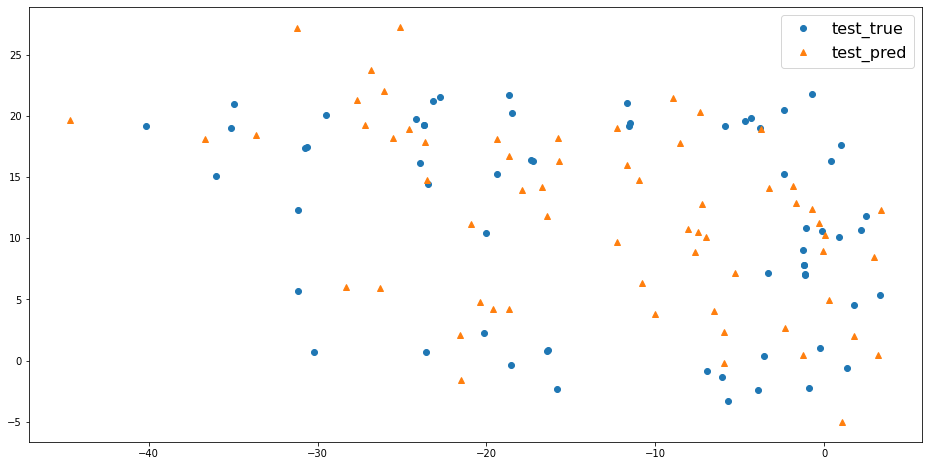

In [661]:
for t in train:
    pxy_train = t[1]
    tod_train = t[0]
    pxy_train_ = rtt_cnn(t)[0]

for ts in test:
    pxy_test = ts[1]
    tod_test = ts[0]
    pxy_test_ = rtt_cnn(ts)[0]

plt.figure(figsize=(16, 8))
# pxy_train  = pxy_train*pxy_std.to_numpy()+pxy_mean.to_numpy()
# pxy_train_ = pxy_train_*pxy_std.to_numpy()+pxy_mean.to_numpy()
# plt.plot(pxy_train[:, 0],  pxy_train[:, 1], 'o', label='train_true')
# plt.plot(pxy_train_[:, 0], pxy_train_[:, 1], '^', label='train_pred')

# pxy_test  = pxy_test*pxy_std.to_numpy()+pxy_mean.to_numpy()
# pxy_test_ = pxy_test_*pxy_std.to_numpy()+pxy_mean.to_numpy()
plt.plot(pxy_test[:, 0],  pxy_test[:, 1], 'o', label='test_true')
plt.plot(pxy_test_[:, 0], pxy_test_[:, 1], '^', label='test_pred')
plt.legend(fontsize=16)

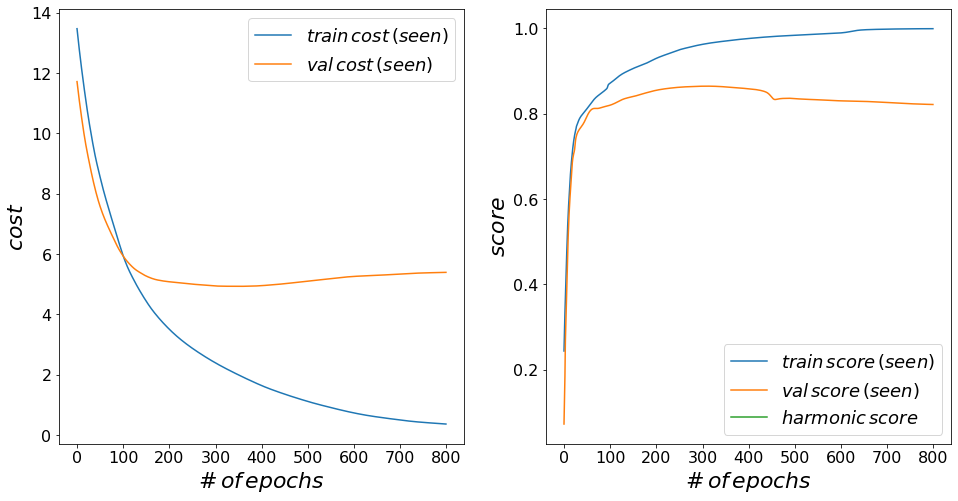

In [662]:
history_figure(rtt_cnn.history)